# A3: Translate your own language
Name: Sitthiwat Damrongpreechar <br>
Student ID: st123994

## 0. Libraries Import

In [ ]:
# install the required packages
# !pip install datasets pythainlp python-crfsuite

In [2]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext, datasets, math
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
# Check the versions of torch and torchtext
torch.__version__, torchtext.__version__

('2.1.0+cu121', '0.16.0+cpu')

In [4]:
# Setting up the device
device=  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# Set the seed value all over the place to make this reproducible.
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Task 1. Get Language Pair

## 1. ETL: Loading the dataset

https://huggingface.co/datasets/scb_mt_enth_2020?library=true

In [6]:
# load datasets from huggingface
from datasets import load_dataset
dataset = load_dataset('scb_mt_enth_2020', 'enth')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Set the source and target language
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

In [8]:
# Check the original dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 801402
    })
    validation: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 100173
    })
    test: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 100177
    })
})

In [9]:
# English sentences
dataset['train']['translation'][0]['en']

'FAR LEFT: Indonesian National Police Chief Tito Karnavian, from left, Philippine National Police Chief Ronald Dela Rosa and Royal Malaysian Police Inspector General Khalid Abu Bakar link arms before the Trilateral Security Meeting in Pasay city, southeast of Manila, Philippines, in June 2017. [THE ASSOCIATED PRESS]'

In [10]:
# Randomly select 16000 examples from the training set, 2000 from the validation set, and 2000 from the test set
from numpy.random import default_rng

rng = default_rng(seed=SEED)

select_idx = rng.choice(len(dataset['train']), size=16000, replace=False)
dataset['train'] = dataset['train'].filter(lambda example, idx: idx in select_idx, with_indices=True)

select_idx = rng.choice(len(dataset['test']), size=2000, replace=False)
dataset['test'] = dataset['test'].filter(lambda example, idx: idx in select_idx, with_indices=True)

select_idx = rng.choice(len(dataset['validation']), size=2000, replace=False)
dataset['validation'] = dataset['validation'].filter(lambda example, idx: idx in select_idx, with_indices=True)

In [11]:
# Confirm the number of examples in the training, validation, and test sets
dataset

DatasetDict({
    train: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 2000
    })
})

In [12]:
# Define the function to extract the 'en' and 'th' columns and remove the 'translation' and 'subdataset' columns
def extract_languages(example):
    return {'en': example['translation']['en'], 'th': example['translation']['th']}

# Map the function to create 'en' and 'th' columns and remove the 'translation' column
dataset['train'] = dataset['train'].map(extract_languages, remove_columns=['translation','subdataset'])
dataset['validation'] = dataset['validation'].map(extract_languages, remove_columns=['translation','subdataset'])
dataset['test'] = dataset['test'].map(extract_languages, remove_columns=['translation','subdataset'])

In [13]:
# Confirming the changes
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'th'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['en', 'th'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['en', 'th'],
        num_rows: 2000
    })
})

## 2. EDA - simple investigation

In [14]:
# Split the dataset into train, validation and test
trains = dataset['train']
valid = dataset['validation']
test = dataset['test']

In [15]:
# check the shape of the datasets
trains.shape, valid.shape, test.shape

((16000, 2), (2000, 2), (2000, 2))

In [16]:
trains[SRC_LANGUAGE][0]

'Foodnavigator-asia.com says the rice is specifically engineered for cultivation in countries such as Indonesia, the Philippines and Bangladesh to reduce vitamin A deficiencies.'

In [17]:
trains[TRG_LANGUAGE][0]

'Foodnavigator-asia.com ระบุว่า ข้าวพันธุ์นี้ได้รับการออกแบบมาสําหรับการเพาะปลูกในประเทศต่าง ๆ อย่างอินโดนีเซีย ฟิลิปปินส์ และบังกลาเทศโดยเฉพาะ เพื่อลดภาวะการขาดวิตามินเอ'

## 3. Preprocessing

https://pythainlp.github.io/docs/2.0/notes/getting_started.html

### 3.1 Tokenizing

In [18]:
# !pip install pythainlp
# !pip install python-crfsuite

In [19]:
# Importing libraries
import pythainlp
pythainlp.__version__

'4.0.2'

In [20]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [22]:
# Tokenization function for Thai language
from pythainlp.tokenize import Tokenizer
tokenizer_th = Tokenizer()
# Test the tokenization function
text_th = 'สวัสดีครับ ผมชื่อสิทธิวัฒน์ครับ'
print("word_tokenize:", tokenizer_th.word_tokenize(text_th))

word_tokenize: ['สวัสดี', 'ครับ', ' ', 'ผม', 'ชื่อ', 'สิทธิ', 'วัฒน์', 'ครับ']


In [23]:
# Tokenization function for English language
from torchtext.data.utils import get_tokenizer
tokenizer_en = get_tokenizer("basic_english")
# Test the tokenization function
text_en = 'Hello, how are you?'
print("word_tokenize:", tokenizer_en(text_en))

word_tokenize: ['hello', ',', 'how', 'are', 'you', '?']


In [24]:
# Add the tokenization function to the token_transform dictionary
token_transform[TRG_LANGUAGE] = tokenizer_th
token_transform[SRC_LANGUAGE] = tokenizer_en

In [25]:
token_transform

{'th': <pythainlp.tokenize.core.Tokenizer at 0x7d74cbd5a6e0>,
 'en': <function torchtext.data.utils._basic_english_normalize(line)>}

In [26]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    if language == SRC_LANGUAGE:
        for sample in data:
            #lowercase the english sentence
            yield token_transform[language](sample[language].lower())
    else: # for thai language
        for sample in data:
            yield token_transform[language].word_tokenize(sample[language].lower())

In [27]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### 3.2 Text to integers (Numericalization)

In [28]:
from torchtext.vocab import build_vocab_from_iterator
# build vocabulary for source and target languages
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(trains, ln),
                                                    min_freq=2, #if not, then everything will be treated as UNK
                                                    specials = special_symbols,
                                                    special_first = True) # indicates whether to insert symbols at the beginning or end of the word_list
    # Set UNK_IDX as the default index. This index is returned when the token is not found.
    # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [29]:
#see some example
vocab_transform[SRC_LANGUAGE](['i', 'love','machine','learning','bruh'])

[15, 261, 239, 1610, 0]

In [30]:
vocab_transform[TRG_LANGUAGE](["ผม","หิว","ข้าว","ครับ","แหวะ"])

[364, 4896, 1592, 393, 0]

In [31]:
# Example of vocabulary in English
mapping_en = vocab_transform[SRC_LANGUAGE].get_itos()
mapping_en[1816]

'colorful'

In [32]:
# Example of vocabulary in Thai
mapping_th = vocab_transform[TRG_LANGUAGE].get_itos()
mapping_th[1816]

'เข้าด้วยกัน'

In [33]:
#let's try unknown vocab and special symbols
mapping_en[0], mapping_en[1], mapping_en[2], mapping_en[3]
#they will all map to <unk> which has 0 as integer

('<unk>', '<pad>', '<sos>', '<eos>')

In [34]:
#check unique vocabularies
len(mapping_en), len(mapping_th)

(12605, 12166)

## 4. Preparing the dataloader

In [35]:
# collate_function
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try: #try to tokenize the sentence if it is english
                txt_input = transform(txt_input)
            except TypeError: #if it is thai, then just word_tokenize
                txt_input = transform.word_tokenize(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# Maximum length for sequence truncation
MAX_LENGTH = 50

# Modify the collate_batch function to truncate sequences
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        # Process source and target texts
        processed_src_text = text_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE].rstrip("\n"))
        processed_trg_text = text_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE].rstrip("\n"))

        # Truncate sequences
        processed_src_text = processed_src_text[:MAX_LENGTH]
        processed_trg_text = processed_trg_text[:MAX_LENGTH]

        src_batch.append(processed_src_text)
        trg_batch.append(processed_trg_text)
        src_len_batch.append(processed_src_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [36]:
# DataLoaders
batch_size = 64

train_loader = DataLoader(trains, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [37]:
# Check the shape of the data
for en, _, th in train_loader:
    print("English:", en.shape, "Thai:", th.shape)
    break

English: torch.Size([64, 50]) Thai: torch.Size([64, 50])


## 5. Design the Model

### 5.1 Encoder Layer

In [39]:
class EncoderLayer(nn.Module):
    def __init__(self, attention, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiheadAttentionLayer(attention, hid_dim, n_heads, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1,src len] #if the token is pad, then it is 0, else 1
        _src, _ = self.self_attention(src, src, src, src_mask) #Q, K, V into the multiheadattentionlayer
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]

        _src = self.feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]

        return src

### 5.2 Encoder

In [40]:
class Encoder(nn.Module):
    def __init__(self, attention, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(attention, hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len  = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)
            #src = [batch size, src len, hid dim]

        return src

### 5.3 Multi Head Attention Layer

#### Additive/Multiplicative Attention Mechanism classes

In [41]:
class Additive(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W1 = nn.Linear(head_dim, head_dim)
        self.W2 = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)
    def forward(self, Q, K):
        Q = Q.unsqueeze(3)
        K = K.unsqueeze(2)
        features = torch.tanh(self.W1(Q) + self.W2(K))
        energy = self.V(features).squeeze(-1)

        return energy

class Multiplicative(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W1 = nn.Linear(head_dim, head_dim)
    def forward(self, Q, K):
        energy = torch.matmul(self.W1(Q), K.permute(0, 1, 3, 2))

        return energy

class General(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K):
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        return energy

In [43]:
class MultiheadAttentionLayer(nn.Module):
    def __init__(self, attention, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.device = device
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)


        self.attention = attention
        if attention == "general":
          self.general = General()
        elif attention == "multiplicative":
          self.multi = Multiplicative(self.head_dim)
        elif attention == "additive":
          self.addi = Additive(self.head_dim)


    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V = [batch size, src len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch size, n heads, query len, head dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #K = [batch size, n heads, key len, head dim]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #V = [batch size, n heads, value len, head dim]

        #Attention mechanism
        if self.attention == "multiplicative":
            energy = self.multi(Q, K)
        elif self.attention == "additive":
            energy = self.addi(Q, K)
        elif self.attention == "general":
            energy = self.general(Q, K)
        else:
            raise ValueError("What is that attention mechanism!")
        # Q = [batch size, n heads, query len, head dim] @ K = [batch size, n heads, head dim, key len] = [batch size, n heads, query len, key len]
        #energy = [batch size, n heads, query len, key len]

        #for the masking attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attentions = torch.softmax(energy, dim=-1)
        #attentions = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attentions), V)
        #[batch size, n heads, query len, key len] @ [batch size, n heads, value len, head dim] = [batch size, n heads, query len, head dim]
        #x= [batch size, n heads, query len, head dim]

        x.permute(0, 2, 1, 3).contiguous() #we can perform .view
        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]

        return x, attentions

### 5.4 Position-wise Feedforward Layer

In [44]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        #x = [batch size, seq len, pf dim]
        x = self.fc2(x)
        #x = [batch size, seq len, hid dim]
        return x

### 5.5 Decoder Layer

In [45]:
class DecoderLayer(nn.Module):
    def __init__(self, attention ,hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_latyer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiheadAttentionLayer(attention, hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiheadAttentionLayer(attention, hid_dim, n_heads, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch size, trg len, hid dim]

        _trg, attentions = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch size, trg len, hid dim]
        #attentions = [batch size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg = self.ff_latyer_norm(trg + self.dropout(_trg))
        #trg = [batch size, trg len, hid dim]

        return trg, attentions

### 5.6 Decoder

In [46]:
class Decoder(nn.Module):
    def __init__(self, attention, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(attention, hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, trg len]

        trg = self.dropout(self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attentions = layer(trg, enc_src, trg_mask, src_mask)
            #trg = [batch size, trg len, hid dim]
            #attentions = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]

        return output, attentions

### 5.7 Seq2Seq (putting them together)

In [47]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx,device):
        super().__init__()
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        return src_mask
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attentions = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attentions = [batch size, n heads, trg len, src len]

        return output, attentions

## 6.Training

In [48]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [49]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [50]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
import torch.optim as optim
import time

In [53]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
attention = "general"

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc_test = Encoder(attention,
              input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec_test = Decoder(attention,
              output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model_test = Seq2SeqTransformer(enc_test, dec_test, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_test.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(12605, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiheadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (general): General()
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0

In [54]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Total Parameters: {sum(params):>6}')
count_parameters(model_test)

Total Parameters: 13472902


#### Training loop for each attention mechanism

In [55]:
model_losses ={}
for attention in ["general", "multiplicative", "additive" ]:
    print(f"\nAttention_Mechanism: {attention}")
    # Load the train, validation and test data for each attention mechanism
    train_loader = DataLoader(trains, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    #get the length of the loaders
    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    #----------------------------------------------------------------------------------------------------
    # Encoder and Decoder for each attention mechanism
    enc = Encoder(attention,
                input_dim,
                hid_dim,
                enc_layers,
                enc_heads,
                enc_pf_dim,
                enc_dropout,
                device)

    dec = Decoder(attention,
                output_dim,
                hid_dim,
                dec_layers,
                dec_heads,
                dec_pf_dim,
                enc_dropout,
                device)
    # Model for each attention mechanism
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)
    #----------------------------------------------------------------------------------------------------
    lr = 0.0005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy loss
    #----------------------------------------------------------------------------------------------------

    best_valid_loss = float('inf')
    num_epochs = 10
    clip       = 1

    save_path = f'/content/models/{model.__class__.__name__}_{attention}.pt'

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)

        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #lower perplexity is better

    # Store the losses for each attention mechanism
    model_losses[attention] = { "train_loss": train_losses, "valid_loss": valid_losses, "train_ppl": [math.exp(x) for x in train_losses] , "valid_ppl":[math.exp(x) for x in valid_losses]}



Attention_Mechanism: general

Epoch: 01 | Time: 0m 24s
	Train Loss: 6.363 | Train PPL: 579.938
	 Val. Loss: 5.940 |  Val. PPL: 379.766

Epoch: 02 | Time: 0m 23s
	Train Loss: 5.909 | Train PPL: 368.347
	 Val. Loss: 5.806 |  Val. PPL: 332.168

Epoch: 03 | Time: 0m 24s
	Train Loss: 5.764 | Train PPL: 318.681
	 Val. Loss: 5.717 |  Val. PPL: 303.994

Epoch: 04 | Time: 0m 28s
	Train Loss: 5.675 | Train PPL: 291.410
	 Val. Loss: 5.681 |  Val. PPL: 293.194

Epoch: 05 | Time: 0m 24s
	Train Loss: 5.614 | Train PPL: 274.119
	 Val. Loss: 5.663 |  Val. PPL: 287.875

Epoch: 06 | Time: 0m 24s
	Train Loss: 5.563 | Train PPL: 260.627
	 Val. Loss: 5.653 |  Val. PPL: 285.037

Epoch: 07 | Time: 0m 24s
	Train Loss: 5.520 | Train PPL: 249.586
	 Val. Loss: 5.627 |  Val. PPL: 277.717

Epoch: 08 | Time: 0m 23s
	Train Loss: 5.460 | Train PPL: 235.177
	 Val. Loss: 5.603 |  Val. PPL: 271.206

Epoch: 09 | Time: 0m 23s
	Train Loss: 5.412 | Train PPL: 224.055
	 Val. Loss: 5.571 |  Val. PPL: 262.802

Epoch: 10 | Tim

In [ ]:
#model_losses

## 7. Testing

In [57]:
# Check the save path
save_path

'/content/models/Seq2SeqTransformer_additive.pt'

In [59]:
# Dictionary to store test losses for each attention mechanism
test_losses = {}

######################Wrong Load the diff model
# Evaluate each attention mechanism
for technique in ["general", "multiplicative", "additive" ]:
    save_path = f'/content/models/Seq2SeqTransformer_{technique}.pt'
  # Load the model state
    try:
      encoder_test = Encoder(technique,
                                input_dim,
                                hid_dim,
                                enc_layers,
                                enc_heads,
                                enc_pf_dim,
                                enc_dropout,
                                device)
      decoder_test = Decoder(technique,
                                  output_dim,
                                  hid_dim,
                                  dec_layers,
                                  dec_heads,
                                  dec_pf_dim,
                                  enc_dropout,
                                  device)
      model_test = Seq2SeqTransformer(encoder_test, decoder_test, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
      model_test.load_state_dict(torch.load(save_path))
    except ValueError:
      print(f"Can not load the model in the {technique} technique.")

    test_loader_eval = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader_length_eval = len(list(iter(test_loader_eval)))
    # Evaluate the model
    test_loss = evaluate(model_test, test_loader_eval, criterion, test_loader_length_eval)
    test_losses[technique] = test_loss

    # Calculate perplexity
    test_ppl = math.exp(test_loss)

    # Display results
    print(f'Attention Technique: {technique}')
    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:.3f} |')

# If you want to store the test losses for further analysis or comparison
print("Test Losses:", test_losses)


Attention Technique: general
| Test Loss: 5.542 | Test PPL: 255.283 |
Attention Technique: multiplicative
| Test Loss: 5.053 | Test PPL: 156.542 |
Attention Technique: additive
| Test Loss: 1.291 | Test PPL: 3.636 |
Test Losses: {'general': 5.542371988296509, 'multiplicative': 5.053326070308685, 'additive': 1.290903516113758}


In [60]:
# Find the best attention mechanism
best_technique = min(test_losses, key=test_losses.get)
best_test_loss = test_losses[best_technique]

print(f'The best attention mechanism is "{best_technique}" with a test loss of {best_test_loss:.3f}.')


The best attention mechanism is "additive" with a test loss of 1.291.


## 8. Evaluation

In [ ]:
# # To Reconstruct Markdown table string
# markdown_table = "|Attentions | Train Loss | Train PPL | Validation Loss | Validation PPL| \n"
# markdown_table += "|-------- | ---------- | ----------- | ---------| ----------|\n"

# for technique in ['general', 'multiplicative', 'additive']:
#     train_losses = model_losses[technique]['train_loss']
#     valid_losses = model_losses[technique]['valid_loss']
#     train_ppl = model_losses[technique]['train_ppl']
#     valid_ppl = model_losses[technique]['valid_ppl']
#     markdown_table += f"| {technique.capitalize()} | {train_losses[-1]:.3f} | {train_ppl[-1]:.3f} | {valid_losses[-1]:.3f} | {valid_ppl[-1]:.3f} | \n"

# # Print Markdown table
# print(markdown_table)

|Attentions | Train Loss | Train PPL | Validation Loss | Validation PPL|
|-------- | ---------- | ----------- | ---------| ----------|
| General | 5.384 | 217.942 | 5.564 | 260.740 |
| Multiplicative | 5.076 | 160.070 | 5.078 | 160.413 |
| Additive | 0.277 | 1.319 | 1.374 | 3.950 |


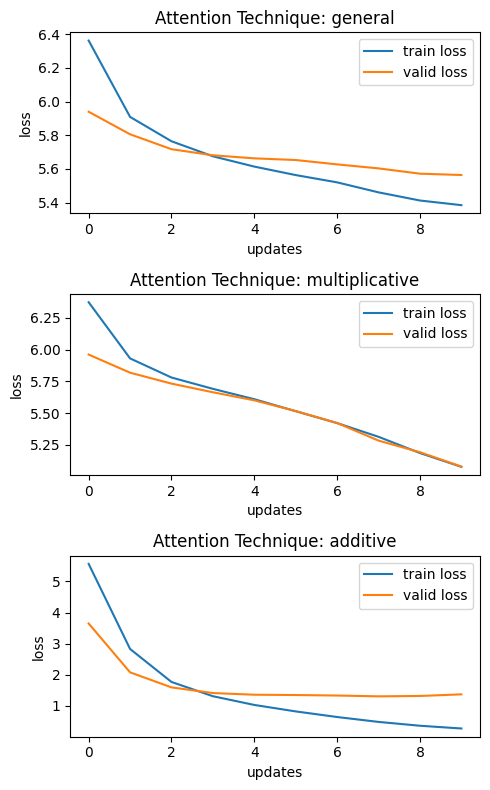

In [64]:
# Plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

for i, technique in enumerate(model_losses):
    ax = axs[i]
    ax.plot(model_losses[technique]['train_loss'], label='train loss')
    ax.plot(model_losses[technique]['valid_loss'], label='valid loss')
    ax.legend()
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')
    ax.set_title(f'Attention Technique: {technique}')

plt.tight_layout()
plt.show()

##### Inference

In [89]:
# Select the sample from the train set
trains[0]

{'en': 'Foodnavigator-asia.com says the rice is specifically engineered for cultivation in countries such as Indonesia, the Philippines and Bangladesh to reduce vitamin A deficiencies.',
 'th': 'Foodnavigator-asia.com ระบุว่า ข้าวพันธุ์นี้ได้รับการออกแบบมาสําหรับการเพาะปลูกในประเทศต่าง ๆ อย่างอินโดนีเซีย ฟิลิปปินส์ และบังกลาเทศโดยเฉพาะ เพื่อลดภาวะการขาดวิตามินเอ'}

In [90]:
# make it to be a sample
sample = trains[0].copy()

In [91]:
sample['en']

'Foodnavigator-asia.com says the rice is specifically engineered for cultivation in countries such as Indonesia, the Philippines and Bangladesh to reduce vitamin A deficiencies.'

In [92]:
sample['th']

'Foodnavigator-asia.com ระบุว่า ข้าวพันธุ์นี้ได้รับการออกแบบมาสําหรับการเพาะปลูกในประเทศต่าง ๆ อย่างอินโดนีเซีย ฟิลิปปินส์ และบังกลาเทศโดยเฉพาะ เพื่อลดภาวะการขาดวิตามินเอ'

In [93]:
# Convert the source language text to tensors
src_text = text_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE]).to(device)
src_text

tensor([   2,    0,    4,  984,  973,    5,  732,   18, 2178, 3024,   14, 6334,
          11,  573,  214,   30, 2589,    6,    5, 1847,    7, 7426,    8,  892,
        1325,   10,    0,    4,    3], device='cuda:0')

In [94]:
# Convert the target language text to tensors
trg_text = text_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE]).to(device)
trg_text

tensor([   2,    0,   66, 1419,    4,  741,   32,    4, 1592, 4087,   26,   93,
           9,  190, 3204,   45,   29,    9, 4534,  540,  487,    4,   35, 2086,
           4, 1382,    4,    7, 8252,  563,    4,   55,  312, 1750,    9, 1041,
        1354,  633,    3], device='cuda:0')

In [95]:
# Add a batch dimension to the source and target text
src_text = src_text.reshape(1, -1)  #because batch_size is 1
trg_text = trg_text.reshape(1, -1)
src_text.shape, trg_text.shape

(torch.Size([1, 29]), torch.Size([1, 39]))

In [96]:
# get the text length
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [97]:
#Save vocab_transform and token_transform
import pickle
with open('vocab_transform.pkl', 'wb') as f:
    pickle.dump(vocab_transform, f)
with open('token_transform.pkl', 'wb') as f:
    pickle.dump(token_transform, f)

In [98]:
#Load vocab_transform and token_transform
with open('vocab_transform.pkl', 'rb') as f:
  vocab_transform_atten_test = pickle.load(f)
with open('token_transform.pkl', 'rb') as f:
  token_transform_atten_test = pickle.load(f)

In [99]:
# Define the hyperparameters for the model
input_dim_atten_test   = len(vocab_transform_atten_test[SRC_LANGUAGE])
output_dim_atten_test  = len(vocab_transform_atten_test[TRG_LANGUAGE])
hid_dim_atten_test = 256
enc_layers_atten_test = 3
dec_layers_atten_test = 3
enc_heads_atten_test = 8
dec_heads_atten_test = 8
enc_pf_dim_atten_test = 512
dec_pf_dim_atten_test = 512
enc_dropout_atten_test = 0.1
dec_dropout_atten_test = 0.1
src_pad_idx_atten_test= PAD_IDX
trg_pad_idx_atten_test = PAD_IDX

In [104]:
# Perform inference on new data
inference_storage={}
for technique in ["general", "additive", "multiplicative"]:
  save_path_atten_test = f'/content/models/Seq2SeqTransformer_{technique}.pt'
  # Load the model state
  try:
    encoder_atten_test = Encoder(technique,
                                input_dim,
                                hid_dim,
                                enc_layers,
                                enc_heads,
                                enc_pf_dim,
                                enc_dropout,
                                device)
    decoder_atten_test = Decoder(technique,
                                  output_dim,
                                  hid_dim,
                                  dec_layers,
                                  dec_heads,
                                  dec_pf_dim,
                                  enc_dropout,
                                  device)
    model_atten_test = Seq2SeqTransformer(encoder_atten_test,decoder_atten_test,src_pad_idx_atten_test,trg_pad_idx_atten_test, device).to(device)
    model_atten_test.load_state_dict(torch.load(save_path_atten_test))
  except ValueError:
    print(f"Can not load the model in the additive technique.")

  # Set model to evaluation mode
  model_atten_test.eval()

  with torch.no_grad():
    output_atten_test, attentions_atten_test = model_atten_test(src_text, trg_text) #turn off teacher forcing
    inference_storage[technique] = {'output':output_atten_test, 'attentions': attentions_atten_test}



In [105]:
# Check the shape of stored output and attentions for each attention mechanism
len(inference_storage)

3

In [106]:
# Get the output of additive attention mechanism
output_additive,_ = inference_storage["additive"].items()

In [107]:
output_additive = output_additive[1].squeeze(0)
output_additive = output_additive[1:]

output_max = output_additive.argmax(1) #returns max indices
output_max

mapping = vocab_transform_atten_test[TRG_LANGUAGE].get_itos()

for token in output_max:
    print(mapping[token.item()])

.
 
 
ว่า
 
ข้าว
มาตร
ข้าว
เพื่อ
มาส
การ
ส่งเสริม
การ
ํา
รุ
ไฟฟ้า
เพาะปลูก
ในประเทศ
ฟิลิปปินส์
 
และ
ต่อเนื่อง
 
 
 
โดย
อัตราดอกเบี้ย
เข้ากับ
:
ซึ่ง
การ
การ
การ
พิมพ์
ครั้งแรก
"
ล
เกรด


#### Attention

In [108]:
# Store the source and target tokens and attentions for each attention mechanism (later use for visualization)
for i,k in inference_storage.items():
  attentions_infer= k['attentions']
  attentions_infer = attentions_infer[0, 0, :, :]
  src_tokens = ['<sos>'] + token_transform_atten_test[SRC_LANGUAGE](sample[SRC_LANGUAGE]) + ['<eos>']
  trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
  inference_storage[i]['src_tokens'] = src_tokens
  inference_storage[i]['trg_tokens'] = trg_tokens
  inference_storage[i]['attentions_table'] = attentions_infer

In [109]:
inference_storage['general'].keys()

dict_keys(['output', 'attentions', 'src_tokens', 'trg_tokens', 'attentions_table'])

In [110]:
# Download Thai Font
!wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf

--2024-02-08 11:50:24--  https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf [following]
--2024-02-08 11:50:25--  https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90220 (88K) [application/octet-stream]
Saving to: ‘Sarabun-Regular.ttf’

Sarabun-Regular.ttf 100%[===================>]  88.11K  --.-KB/s    in 0.001s  

2024-02-08 11:50:25 (57.9 MB/s) - ‘Sarabun-Regular.ttf’ saved [90220/90220]



In [111]:
# Create a function to display the attention
import matplotlib.ticker as ticker
import matplotlib
def display_attention(sentence, translation, attention):
    # Set the font family to a font that supports Thai characters
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
    matplotlib.rc('font', family='Sarabun')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


    plt.show()
    plt.close()

In [113]:
# Check the shape of the attentions table for each attention mechanism
for i,k in inference_storage.items():
    print( i,k['attentions_table'].shape)

general torch.Size([39, 29])
additive torch.Size([39, 29])
multiplicative torch.Size([39, 29])


<ipython-input-111-259cd7424633>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-111-259cd7424633>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


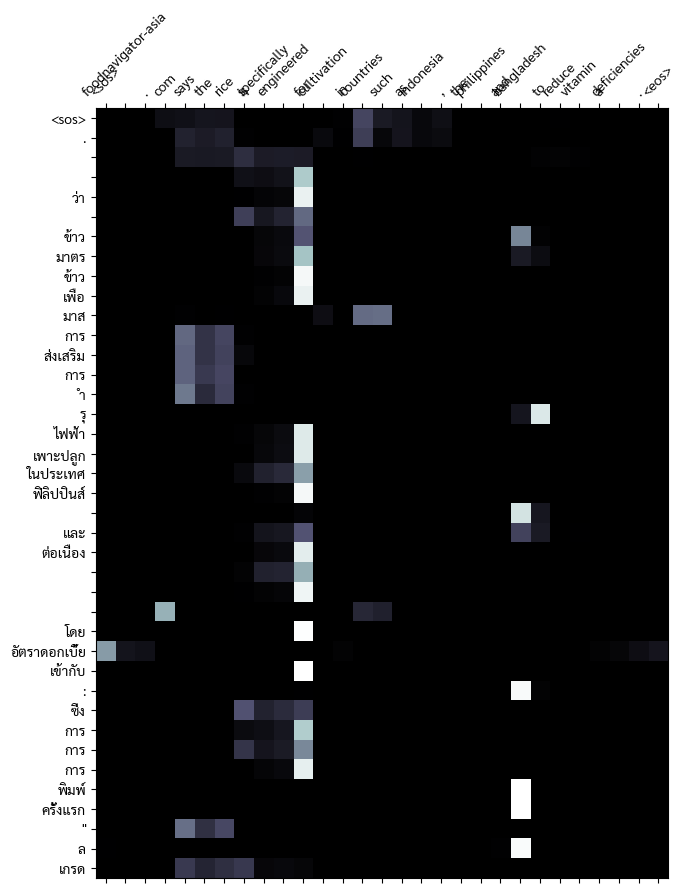

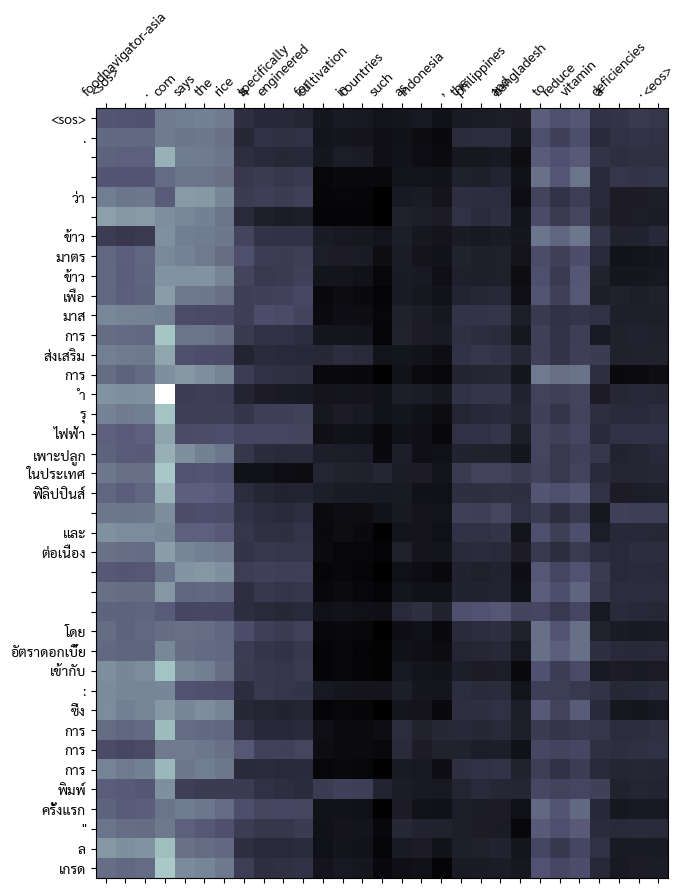

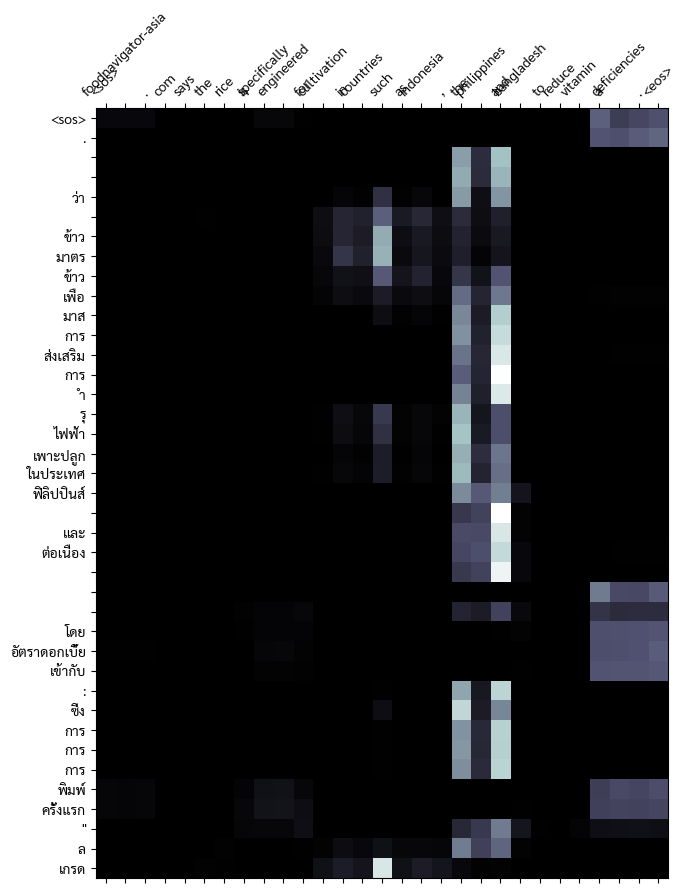

In [114]:
# Display the attention weights for the all attention mechanism in heatmap
for i,k in inference_storage.items():
  display_attention(k['src_tokens'], k['trg_tokens'], k['attentions_table'])

##### Upper are the heatmaps corresponding to three attention techniques, named downward respectively: 1. General attention, 2. Additive, and 3. Multiplicative.

Based on the assessment of three attention mechanisms, the additive mechanism stands out with the highest score, making it the preferred choice for English to Thai translation. Upon examining the attention heatmaps, it becomes apparent that the additive mechanism displays a more widespread attention distribution compared to the others. While the others exhibit active involvement with certain words such as 'the', 'and', 'for', and 'to', the additive mechanism's broader focus suggests a deeper understanding of intricate word relationships, making it more adept at understanding subtle linguistic nuances. 